In [1]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv('./dataset/titanic.csv')

data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [3]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [4]:
# retain only the first cabin if more than 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan

data['cabin'] = data['cabin'].apply(get_first_cabin)

In [5]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'

data['title'] = data['name'].apply(get_title)

In [6]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [7]:
# drop unnecessary variables

data.drop(labels=['name', 'ticket', 'boat', 'body', 'home.dest'], axis=1, inplace=True)

data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


## Data Exploration

In [8]:
target = 'survived'

In [9]:
vars_num = [c for c in data.columns if data[c].dtypes!='O' and c!=target]
vars_cat = [c for c in data.columns if data[c].dtypes=='O']
print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 5
Number of categorical variables: 4


In [10]:
vars_cat

['sex', 'cabin', 'embarked', 'title']

In [11]:
vars_num

['pclass', 'age', 'sibsp', 'parch', 'fare']

In [12]:
# Find categorical variables with missing values

data[vars_cat].isnull().mean().sort_values(ascending=False)

cabin       0.774637
embarked    0.001528
sex         0.000000
title       0.000000
dtype: float64

In [13]:
data[vars_num].isnull().mean().sort_values(ascending=False)

age       0.200917
fare      0.000764
pclass    0.000000
sibsp     0.000000
parch     0.000000
dtype: float64

In [14]:
# Determine cardinality of categorical variables
data[vars_cat].nunique()

sex           2
cabin       181
embarked      3
title         5
dtype: int64

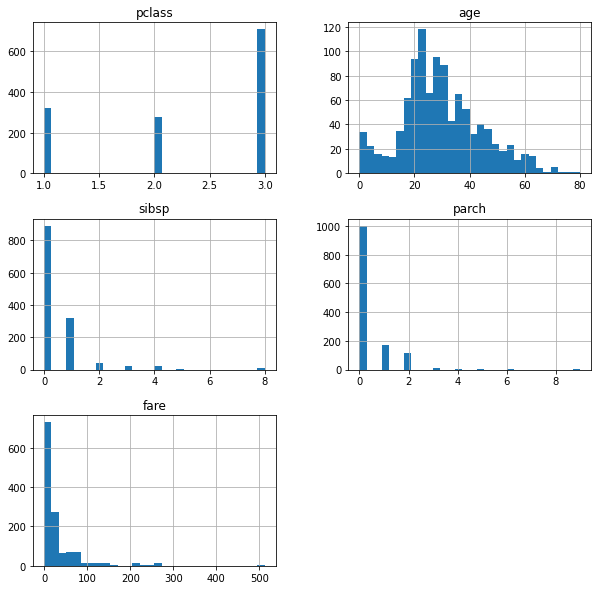

In [15]:
# Determine the distribution of numerical variables
data[vars_num].hist(bins=30, figsize=(10,10))
plt.show()

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

# Feature Engineering

In [17]:
X_train['cabin'] = X_train['cabin'].str[0]
X_test['cabin'] = X_test['cabin'].str[0]

X_train['cabin'].unique()

array([nan, 'E', 'F', 'A', 'C', 'D', 'B', 'T', 'G'], dtype=object)

In [18]:
# replace the missing values in numerical values

for var in ['age', 'fare']:
    median_val = X_train[var].median()
    print(var, median_val)

    # add binary missing indicator (in train and test)
    X_train[var + '_na'] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var + '_na'] = np.where(X_test[var].isnull(), 1, 0)

    # replace missing values by the median (in train and test)
    X_train[var].fillna(median_val, inplace=True)
    X_test[var].fillna(median_val, inplace=True)

# check that we have no more missing values in the engineered variables
X_train[['age', 'fare']].isnull().sum()

age 28.0
fare 14.4542


age     0
fare    0
dtype: int64

In [19]:
with_string_missing = ['cabin', 'embarked']

X_train[with_string_missing] = X_train[with_string_missing].fillna('Missing')
X_test[with_string_missing] = X_test[with_string_missing].fillna('Missing')

In [20]:
X_train.isnull().sum()

pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
cabin       0
embarked    0
title       0
age_na      0
fare_na     0
dtype: int64

In [21]:
# Remove Rare label

def find_frequent_labels(df, var, rare_perc):
    df = df.copy()
    tmp = df.groupby(var)[var].count() / len(df)
    return tmp[tmp > rare_perc].index

for var in vars_cat:
    frequent_ls = find_frequent_labels(X_train, var, 0.05)
    X_train[var] = np.where(X_train[var].isin(frequent_ls), X_train[var], 'Rare')
    X_test[var] = np.where(X_test[var].isin(frequent_ls), X_test[var], 'Rare')

In [22]:
X_train[vars_cat].nunique()

sex         2
cabin       3
embarked    4
title       4
dtype: int64

In [23]:
# One hot encoding
def replace_categories(train, test, y_train, var, target):
    tmp = pd.concat([X_train, y_train], axis=1)
    ordered_labels = tmp.groupby([var])[target].mean().sort_values().index
    ordinal_label = {k:i for i, k in enumerate(ordered_labels, 0)}

    print(var, ordinal_label)
    print()

    train[var] = train[var].map(ordinal_label)
    test[var] = test[var].map(ordinal_label)

In [24]:
for var in vars_cat:
    replace_categories(X_train, X_test, y_train, var, target)

sex {'male': 0, 'female': 1}

cabin {'Missing': 0, 'C': 1, 'Rare': 2}

embarked {'S': 0, 'Q': 1, 'C': 2, 'Rare': 3}

title {'Mr': 0, 'Rare': 1, 'Miss': 2, 'Mrs': 3}



In [26]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

In [27]:
X_train.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na,fare_na
0,0.835808,-0.761042,-0.370162,-0.478911,-0.455423,-0.504782,-0.525480,-0.606358,-0.801644,-0.494921,-0.03092
1,-1.542157,1.313987,0.904029,-0.478911,-0.455423,1.971555,2.158311,1.868716,0.885434,-0.494921,-0.03092
2,0.835808,-0.761042,-0.131251,-0.478911,-0.455423,-0.508533,-0.525480,0.631179,-0.801644,2.020526,-0.03092
3,0.835808,1.313987,-0.927621,-0.478911,-0.455423,-0.507717,-0.525480,-0.606358,0.885434,-0.494921,-0.03092
4,-0.353174,-0.761042,-0.051614,0.434422,-0.455423,-0.248980,-0.525480,-0.606358,-0.801644,-0.494921,-0.03092


In [28]:
model = LogisticRegression(random_state=4)

model.fit(X_train, y_train)

LogisticRegression(random_state=4)

In [30]:
class_ = model.predict(X_train)
pred = model.predict_proba(X_train)[:,1]

# determine mse and rmse
print('train roc-auc: {}'.format(roc_auc_score(y_train, pred)))
print('train accuracy: {}'.format(accuracy_score(y_train, class_)))

train roc-auc: 0.856904945904173
train accuracy: 0.8051575931232091


In [31]:
# make predictions for test set
class_ = model.predict(X_test)
pred = model.predict_proba(X_test)[:,1]

# determine mse and rmse
print('test roc-auc: {}'.format(roc_auc_score(y_test, pred)))
print('test accuracy: {}'.format(accuracy_score(y_test, class_)))

test roc-auc: 0.8555246913580248
test accuracy: 0.7977099236641222
